In [1]:
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics

In [4]:
true_label = pd.read_csv('val.csv',index_col=0) # 진짜 정담
pred = pd.read_csv('../prediction/val_data_small_aug.csv') # inference 한거

In [5]:
# aistage에서 제공하는 num_to_label을 사용안하고 논문에서 나온 num_tolabel을 사용함 이유는 보기 편하게 바꾸려고...
label_to_num = {'no_relation': 0, 'org:top_members/employees': 10, 'org:members': 6, 'org:product': 8, 'per:title': 29, 'org:alternate_names': 4, 'per:employee_of': 18, \
 'org:place_of_headquarters': 3, 'per:product': 27, 'org:number_of_employees/members': 11, 'per:children': 22, 'per:place_of_residence': 16, 'per:alternate_names': 20, \
 'per:other_family': 25, 'per:colleagues': 26, 'per:origin': 17, 'per:siblings': 23, 'per:spouse': 24, 'org:founded': 2, 'org:political/religious_affiliation': 7, \
 'org:member_of': 5, 'per:parents': 21, 'org:dissolved': 1, 'per:schools_attended': 19, 'per:date_of_death': 13, 'per:date_of_birth': 12, 'per:place_of_birth': 14, \
 'per:place_of_death': 15, 'org:founded_by': 9, 'per:religion': 28}

In [6]:
label_to_num = sorted(label_to_num.items(), key=lambda kv:kv[1])

In [7]:
label_to_num = {each[0]:each[1] for each in label_to_num}

# Confusion Matrix

In [8]:
actual = list(true_label.label.map(label_to_num))
predicted = list(pred.pred_label.map(label_to_num))

In [9]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

In [10]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label_to_num.keys()))

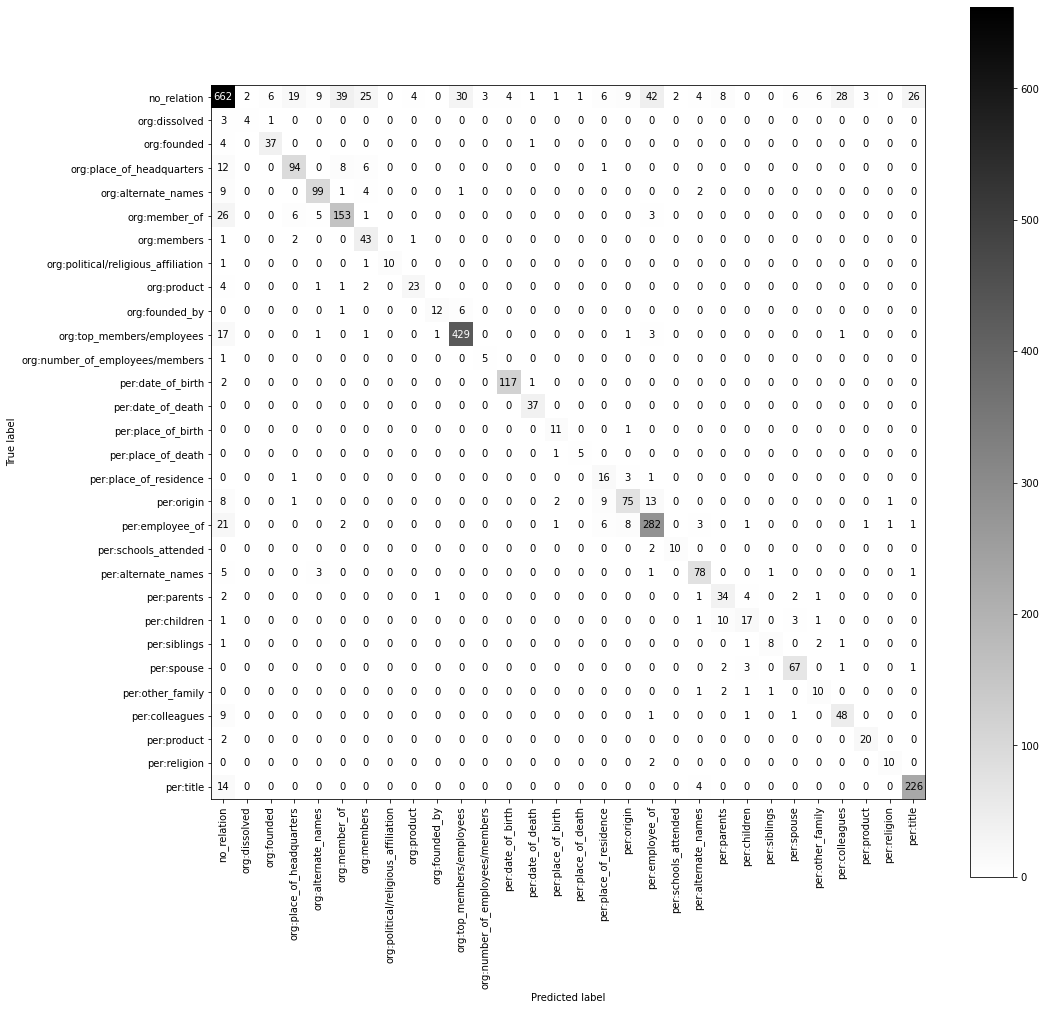

In [11]:
fig, ax = plt.subplots(figsize=(16,16))
cm_display.plot(ax=ax, cmap="binary", xticks_rotation='vertical')
plt.show()

# Bat plot

In [12]:
# Base model이랑 비교하는건 그냥 없앰
# # 비교를 하고 싶은 데이터 임포트
# base_pred = pd.read_csv('../prediction/val_data_small.csv')
# base_predicted = list(base_pred.pred_label.map(label_to_num))

# confusion_matrix_base = metrics.confusion_matrix(actual, base_predicted)

In [13]:
# 위에서 Inference 한거에 대한 percentage 구하기
recall = []
for idx, each in enumerate(confusion_matrix):
    recall.append(each[idx] / sum(each))
recall = pd.Series(recall)

precision = []
for idx, each in enumerate(confusion_matrix.T):
    precision.append(each[idx] / sum(each))
precision = pd.Series(precision)

In [14]:
# recall을 기준으로 내림차순으로 정리
order_idx = recall.sort_values(ascending=False).index

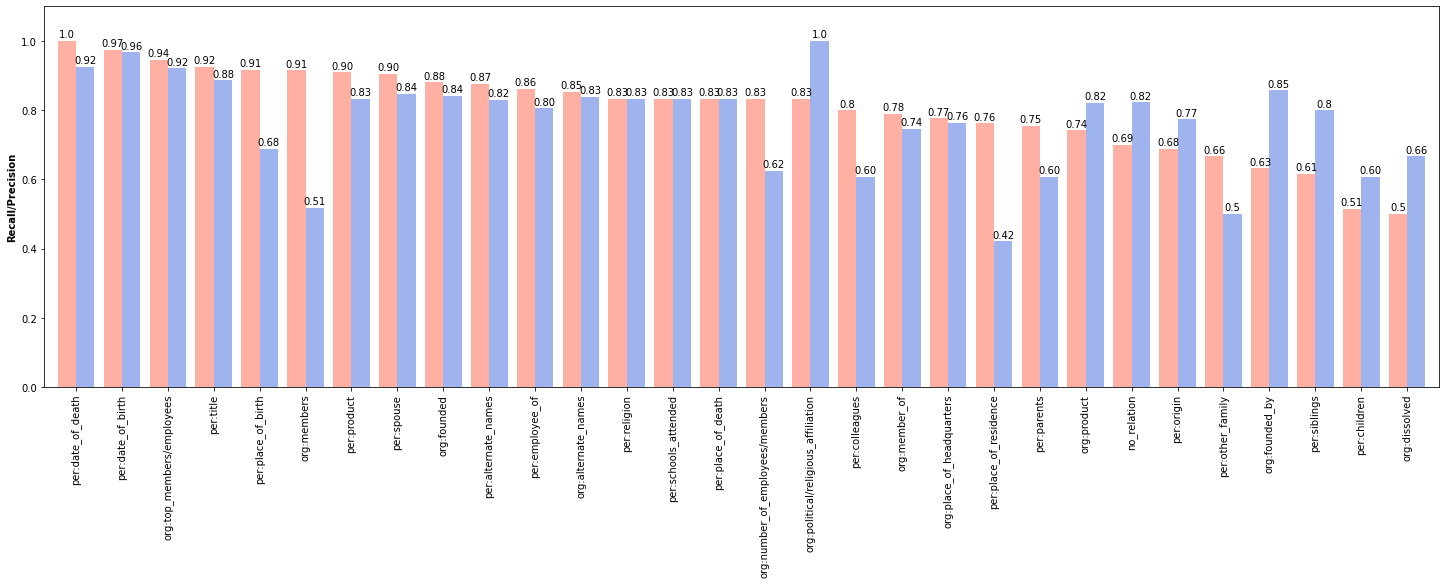

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(25, 7), sharey=True)
index = np.arange(len(list(label_to_num.keys())))

width = 0.4
axes.bar(index-width/2,recall[order_idx],color='tomato', alpha=0.5, width=width)
axes.bar(index+width/2,precision[order_idx],color='royalblue', alpha=0.5, width=width)

axes.set_ylabel('Recall/Precision', fontweight='bold')
axes.margins(0.01, 0.1)

for idx, value in zip(recall.index, recall[order_idx]):
    axes.text(idx-width/2, value+0.01, s=str(value)[:4],
                 ha='center', 
                )
    
for idx, value in zip(precision.index, precision[order_idx]):
    axes.text(idx+width/2, value+0.01, s=str(value)[:4],
                 ha='center', 
                )

axes.set_xticks(index)
label_list = np.array((list(label_to_num.keys())))[order_idx]

axes.set_xticklabels(label_list)
plt.xticks(rotation=90)
plt.show()

In [16]:
# 위에서 Inference 한거에 대한 percentage 구하기
confusion_matrix = metrics.confusion_matrix(actual, predicted)

TP = []
total = []
for idx, each in enumerate(confusion_matrix):
    TP.append(each[idx])
    total.append(sum(each))
TP = pd.Series(TP)
total = pd.Series(total)

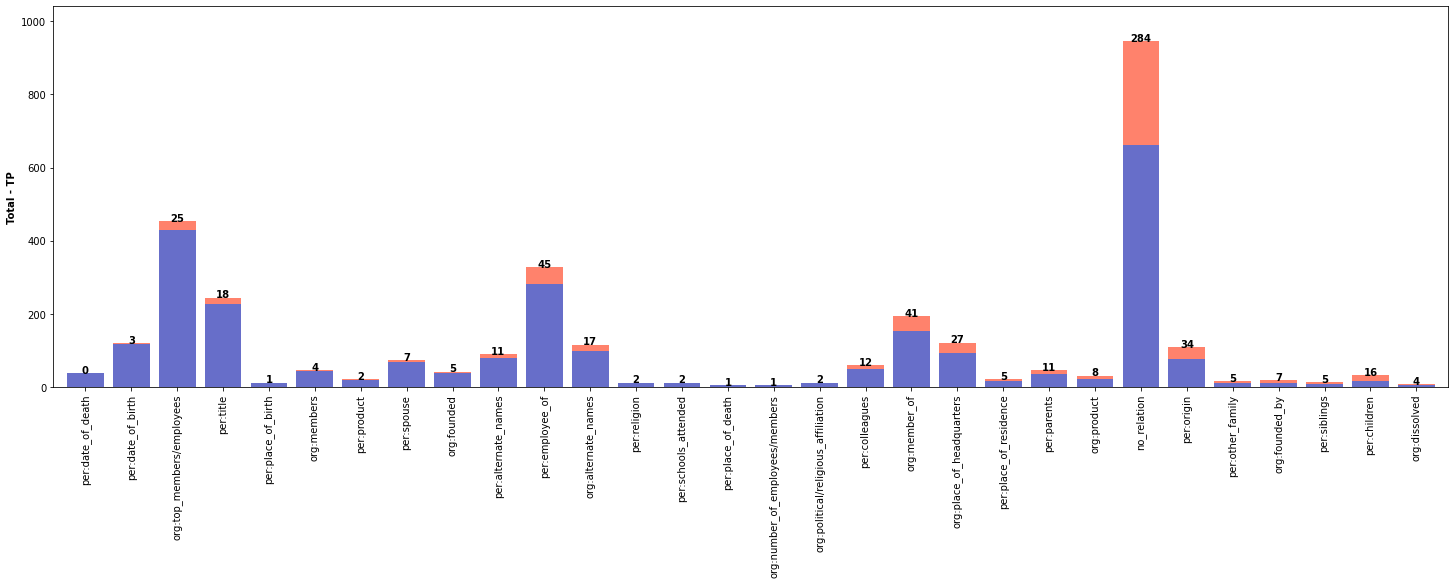

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(25, 7), sharey=True)

#axes.bar(list(label_to_num.keys()),percentage_base,color='tomato',alpha=0.5)
axes.bar(list(label_to_num.keys()),total[order_idx],color='tomato', alpha=0.8)
axes.bar(list(label_to_num.keys()),TP[order_idx],color='royalblue', alpha=0.8)

axes.set_ylabel('Total - TP', fontweight='bold')
axes.margins(0.01, 0.1)

for idx, value, value2 in zip(TP.index, TP[order_idx], total[order_idx]):
    axes.text(idx, value2+0.01, s=str(value2-value)[:5],
                 ha='center',fontweight='bold')
    
axes.set_xticks(index)
label_list = np.array((list(label_to_num.keys())))[order_idx]
axes.set_xticklabels(label_list)

plt.xticks(rotation=90)
plt.show()

# Case Analysis

In [19]:
!pip install transformers-interpret --quiet

In [36]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
# model_name = "x"
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
model_config =  AutoConfig.from_pretrained('xlm-roberta-large')
model_config.num_labels = 30
model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-large',config=model_config)
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

Embedding(250002, 1024, padding_idx=1)